In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from matplotlib import patches
from matplotlib.animation import ArtistAnimation
from IPython import display

In [2]:
class DifferentialDriveRobot():
    def __init__(self,
                 wheel_base: float = 1,  # [m] distance between wheels
                 robot_width=1,  # [m]
                 robot_length=1,  # [m]
                 max_linear_vel: float = 2.0,  # [m/s]
                 max_angular_vel: float = 2.0,  # [rad/s]
                 obstacle_circles: np.ndarray = np.array([[-2.0, 1.0, 1.0], [2.0, -1.0, 1.0]]),  # [obs_x, obs_y, obs_radius]
                 delta_t: float = 0.05,  # [s]
                 visualize: bool = True,
                ) -> None:
        """state variables:
            x: x-axis position [m]
            y: y-axis position [m]
            yaw: orientation [rad]
        control input:
            v: linear velocity [m/s]
            w: angular velocity [rad/s]
        """
        # robot parameters
        self.wheel_base = wheel_base  # [m] distance between wheels
        self.robot_w = robot_width
        self.robot_l = robot_length
        self.max_linear_vel = max_linear_vel  # [m/s]
        self.max_angular_vel = max_angular_vel  # [rad/s]
        self.delta_t = delta_t  # [s]
        # obstacle parameters
        self.obstacle_circles = obstacle_circles
        # visualization settings
        self.view_x_lim_min, self.view_x_lim_max = -10.0, 10.0
        self.view_y_lim_min, self.view_y_lim_max = -10.0, 10.0
        # reset environment
        self.visualize_flag = visualize
        self.reset()

    def reset(self,
              init_state: np.ndarray = np.array([0.0, 0.0, 0.0]),  # [x, y, yaw]
             ) -> None:
        # reset state variables
        self.state = init_state
        # clear animation frames
        self.frames = []

        if self.visualize_flag:
            # prepare figure
            self.fig = plt.figure(figsize=(5, 5))
            self.main_ax = plt.subplot2grid((1, 1), (0, 0))
            # graph layout settings
            # main view
            self.main_ax.set_aspect('auto')
            self.main_ax.set_xlim(self.view_x_lim_min, self.view_x_lim_max)
            self.main_ax.set_ylim(self.view_y_lim_min, self.view_y_lim_max)
            self.main_ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            self.main_ax.tick_params(bottom=False, left=False, right=False, top=False)
            # apply tight layout
            self.fig.tight_layout()

    def update(self,
               u: np.ndarray,
               delta_t: float = 0.0,
               append_frame: bool = True,
               # predicted optimal trajectory from mppi
               optimal_traj: np.ndarray = np.empty(0),
               sampled_traj_list: np.ndarray = np.empty(0),  # sampled trajectories from mppi
              ) -> None:
        # keep previous states
        x, y, yaw = self.state
        # prepare params
        dt = self.delta_t if delta_t == 0.0 else delta_t
        # limit control inputs
        v = np.clip(u[0], -self.max_linear_vel, self.max_linear_vel)
        w = np.clip(u[1], -self.max_angular_vel, self.max_angular_vel)
        # update state variables using differential drive kinematics
        new_x = x + v * np.cos(yaw) * dt
        new_y = y + v * np.sin(yaw) * dt
        new_yaw = yaw + w * dt
        self.state = np.array([new_x, new_y, new_yaw])
        # record frame
        if append_frame:
            self.append_frame(v, w, optimal_traj, sampled_traj_list)

    def get_state(self) -> np.ndarray:
        return self.state.copy()

    def append_frame(self, v: float, w: float, optimal_traj: np.ndarray, sampled_traj_list: np.ndarray) -> list:
        # get current states
        x, y, yaw = self.state
        # draw the robot shape
        vw, vl = self.robot_w, self.robot_l
        robot_shape_x = [- vl, - vl, + vl, + vl, - vl, - vl]
        robot_shape_y = [0.0, + vw, + vw, - vw, - vw, 0.0]
        rotated_robot_shape_x, rotated_robot_shape_y = \
            self._affine_transform(robot_shape_x, robot_shape_y, yaw, [0, 0])
        frame = self.main_ax.plot(rotated_robot_shape_x, rotated_robot_shape_y, color='black', linewidth=2.0, zorder=3)

        # draw wheels
        ww, wl = 0.3, 0.6  # [m]
        wheel_shape_x = np.array([- wl, - wl, + wl, + wl, - wl, - wl])
        wheel_shape_y = np.array([0.0, + ww, + ww, - ww, - ww, 0.0])

        # caster wheel
        caster_x = - vl * np.cos(yaw)
        caster_y = - vl * np.sin(yaw)
        caster_circle = patches.Circle([caster_x, caster_y], radius=0.4, fc='black', ec='black', zorder=3)
        frame += [self.main_ax.add_artist(caster_circle)]

        # left wheel
        wheel_shape_l_x, wheel_shape_l_y = \
            self._affine_transform(wheel_shape_x, wheel_shape_y, 0.0, [vl, vw])
        wheel_l_x, wheel_l_y = \
            self._affine_transform(wheel_shape_l_x, wheel_shape_l_y, yaw, [0, 0])
        frame += self.main_ax.fill(wheel_l_x, wheel_l_y, color='black', zorder=3)

        # right wheel
        wheel_shape_r_x, wheel_shape_r_y = \
            self._affine_transform(wheel_shape_x, wheel_shape_y, 0.0, [vl, -vw])
        wheel_r_x, wheel_r_y = \
            self._affine_transform(wheel_shape_r_x, wheel_shape_r_y, yaw, [0, 0])
        frame += self.main_ax.fill(wheel_r_x, wheel_r_y, color='black', zorder=3)

        # draw the robot center circle
        robot_center = patches.Circle([0, 0], radius=vw/20.0, fc='white', ec='black', linewidth=2.0, zorder=6)
        frame += [self.main_ax.add_artist(robot_center)]

        # draw the information text
        text = "v = {v:>+6.2f} [m/s], ω= {w:>+6.2f} [rad/s]".format(v=v, w=w)
        frame += [self.main_ax.text(0.5, 0.02, text, ha='center', transform=self.main_ax.transAxes, fontsize=12, fontfamily='monospace')]

        # draw the predicted optimal trajectory from mppi
        if optimal_traj.any():
            optimal_traj_x_offset = np.ravel(optimal_traj[:, 0]) - np.full(optimal_traj.shape[0], x)
            optimal_traj_y_offset = np.ravel(optimal_traj[:, 1]) - np.full(optimal_traj.shape[0], y)
            frame += self.main_ax.plot(optimal_traj_x_offset, optimal_traj_y_offset, color='blue', linestyle="solid", linewidth=1.5, zorder=5)

        # draw the sampled trajectories from mppi
        if sampled_traj_list.any():
            min_alpha_value = 0.25
            max_alpha_value = 0.35
            for idx, sampled_traj in enumerate(sampled_traj_list):
                # draw darker for better samples
                alpha_value = (1.0 - (idx+1)/len(sampled_traj_list)) * \
                               (max_alpha_value - min_alpha_value) + min_alpha_value
                sampled_traj_x_offset = np.ravel(sampled_traj[:, 0]) - np.full(sampled_traj.shape[0], x)
                sampled_traj_y_offset = np.ravel(sampled_traj[:, 1]) - np.full(sampled_traj.shape[0], y)
                frame += self.main_ax.plot(sampled_traj_x_offset, sampled_traj_y_offset, color='gray', linestyle="solid", linewidth=0.5, zorder=4, alpha=alpha_value)

        # draw the circular obstacles in the main view
        for obs in self.obstacle_circles:
            obs_x, obs_y, obs_r = obs
            obs_circle = patches.Circle([obs_x-x, obs_y-y], radius=obs_r, fc='white', ec='black', linewidth=2.0, zorder=0)
            frame += [self.main_ax.add_artist(obs_circle)]

        # draw goal
        goal_circle = patches.Circle([15-x, 5-y], radius=0.5, fc='red', ec='red', linewidth=1.0, zorder=0)
        frame += [self.main_ax.add_artist(goal_circle)]
        # append frame
        self.frames.append(frame)

    # rotate shape and return location on the x-y plane.
    def _affine_transform(self, xlist: list, ylist: list, angle: float, translation: list = [0.0, 0.0]) -> Tuple[list, list]:
        transformed_x = []
        transformed_y = []
        if len(xlist) != len(ylist):
            print("[ERROR] xlist and ylist must have the same size.")
            raise AttributeError

        for i, xval in enumerate(xlist):
            transformed_x.append((xlist[i])*np.cos(angle)-(ylist[i])*np.sin(angle)+translation[0])
            transformed_y.append((xlist[i])*np.sin(angle)+(ylist[i])*np.cos(angle)+translation[1])
        transformed_x.append(transformed_x[0])
        transformed_y.append(transformed_y[0])
        return transformed_x, transformed_y

    def show_animation(self, interval_ms: int) -> None:
        ani = ArtistAnimation(self.fig, self.frames, interval=interval_ms)  # blit=True
        html = display.HTML(ani.to_jshtml())
        display.display(html)
        plt.close()

In [3]:
class MPPIControllerForDifferentialDrive():
    def __init__(self,
                delta_t: float = 0.05,
                wheel_base: float = 0.5,  # [m] distance between wheels
                robot_width: float = 0.6,  # [m]
                robot_length: float = 0.8,  # [m]
                max_linear_vel: float = 2.0,  # [m/s]
                max_angular_vel: float = 2.0,  # [rad/s]
                goal: np.ndarray = np.array([15.0, 5.0, 0.0]),
                horizon_step_T: int = 30,
                number_of_samples_K: int = 50,
                param_exploration: float = 0.0,
                param_lambda: float = 50.0,
                param_alpha: float = 1.0,
                sigma: np.ndarray = np.array([[0.2, 0.0], [0.0, 0.3]]),
                stage_cost_weight: np.ndarray = np.array([50.0, 50.0, 1.0]),  
                terminal_cost_weight: np.ndarray = np.array([50.0, 50.0, 1.0]), 
                visualize_optimal_traj=False,  
                visualze_sampled_trajs=False,  
                obstacle_circles: np.ndarray = np.array(
                    [[-2.0, 1.0, 1.0], [2.0, -1.0, 1.0]]),  # [obs_x, obs_y, obs_radius]
                collision_safety_margin_rate: float = 1.2, 
                ) -> None:
        
        # mppi parameters
        self.dim_x = 3  # dimension of system state vector [x, y, yaw]
        self.dim_u = 2  # dimension of control input vector [v, w]
        self.T = horizon_step_T  # prediction horizon
        self.K = number_of_samples_K  # number of sample trajectories
        self.param_exploration = param_exploration  # constant parameter of mppi
        self.param_lambda = param_lambda  # constant parameter of mppi
        self.param_alpha = param_alpha  # constant parameter of mppi
        # constant parameter of mppi
        self.param_gamma = self.param_lambda * (1.0 - (self.param_alpha))
        self.Sigma = sigma  # deviation of noise
        self.stage_cost_weight = stage_cost_weight
        self.terminal_cost_weight = terminal_cost_weight
        self.visualize_optimal_traj = visualize_optimal_traj
        self.visualze_sampled_trajs = visualze_sampled_trajs
        # robot parameters
        self.delta_t = delta_t  # [s]
        self.wheel_base = wheel_base  # [m]
        self.robot_w = robot_width  # [m]
        self.robot_l = robot_length  # [m]
        self.max_linear_vel = max_linear_vel  # [m/s]
        self.max_angular_vel = max_angular_vel  # [rad/s]
        self.goal = goal
        # obstacle parameters
        self.obstacle_circles = obstacle_circles
        self.collision_safety_margin_rate = collision_safety_margin_rate
        # mppi variables
        self.u_prev = np.zeros((self.T, self.dim_u))

    def calc_control_input(self, observed_x: np.ndarray) -> Tuple[float, np.ndarray]:
         # load privious control input sequence
        u = self.u_prev
        # set initial x value from observation
        x0 = observed_x
        # prepare buffer
        S = np.zeros((self.K))  # state cost list
        # sample noise
        epsilon = self._calc_epsilon(self.Sigma, self.K, self.T, self.dim_u)  # size is self.K x self.T
        # prepare buffer of sampled control input sequence
        # control input sequence with noise
        v = np.zeros((self.K, self.T, self.dim_u))
        # loop for 0 ~ K-1 samples
        for k in range(self.K):
            # set initial(t=0) state x i.e. observed state of the robot
            x = x0
            # loop for time step t = 1 ~ T
            for t in range(1, self.T+1):
                # get control input with noise
                if k < (1.0-self.param_exploration)*self.K:
                    # sampling for exploitation
                    v[k, t-1] = u[t-1] + epsilon[k, t-1]
                else:
                    v[k, t-1] = epsilon[k, t-1]  # sampling for exploration
                # update x
                x = self._F(x, self._g(v[k, t-1]))
                # add stage cost
                S[k] += self._c(x) + self.param_gamma * \
                                u[t - 1].T @ np.linalg.inv(self.Sigma) @ v[k, t-1]
            # add terminal cost
            S[k] += self._phi(x)

        # compute information theoretic weights for each sample
        w = self._compute_weights(S)
        # calculate w_k * epsilon_k
        w_epsilon = np.zeros((self.T, self.dim_u))
        for t in range(0, self.T):  # loop for time step t = 0 ~ T-1
            for k in range(self.K):
                w_epsilon[t] += w[k] * epsilon[k, t]

        # apply moving average filter for smoothing input sequence
        w_epsilon = self._moving_average_filter(xx=w_epsilon, window_size=10)
        # update control input sequence
        u += w_epsilon
        # calculate optimal trajectory
        optimal_traj = np.zeros((self.T, self.dim_x))
        if self.visualize_optimal_traj:
            x = x0
            for t in range(0, self.T):  # loop for time step t = 0 ~ T-1
                x = self._F(x, self._g(u[t]))
                optimal_traj[t] = x

        # calculate sampled trajectories
        sampled_traj_list = np.zeros((self.K, self.T, self.dim_x))
        # sort samples by state cost, 0th is the best sample
        sorted_idx = np.argsort(S)
        if self.visualze_sampled_trajs:
            for k in sorted_idx:
                x = x0
                for t in range(0, self.T):  # loop for time step t = 0 ~ T-1
                    x = self._F(x, self._g(v[k, t]))
                    sampled_traj_list[k, t] = x

        # update privious control input sequence (shift 1 step to the left)
        self.u_prev[:-1] = u[1:]
        self.u_prev[-1] = u[-1]
        # return optimal control input and input sequence
        return u[0], u, optimal_traj, sampled_traj_list

    def _calc_epsilon(self, sigma: np.ndarray, size_sample: int, size_time_step: int, size_dim_u: int) -> np.ndarray:
        # check if sigma row size == sigma col size == size_dim_u and size_dim_u > 0
        if sigma.shape[0] != sigma.shape[1] or sigma.shape[0] != size_dim_u or size_dim_u < 1:
            print("[ERROR] sigma must be a square matrix with the size of size_dim_u.")
            raise ValueError

        # sample epsilon
        mu = np.zeros((size_dim_u))  # set average as a zero vector
        epsilon = np.random.multivariate_normal(mu, sigma, (size_sample, size_time_step))
        return epsilon

    def _g(self, v: np.ndarray) -> float:
        # limit control inputs
        v[0] = np.clip(v[0], -self.max_linear_vel, self.max_linear_vel)  # limit linear velocity
        v[1] = np.clip(v[1], -self.max_angular_vel, self.max_angular_vel)  # limit angular velocity
        return v

    def _c(self, x_t: np.ndarray) -> float:
        x, y, yaw = x_t
        gx, gy, gyaw = self.goal
        yaw_error = ((yaw - gyaw + np.pi) % (2.0 * np.pi)) - \
                     np.pi  # wrap to [-π, π]

        cost = self.stage_cost_weight[0] * (x - gx) ** 2 \
            + self.stage_cost_weight[1] * (y - gy) ** 2 \
            + self.stage_cost_weight[2] * yaw_error ** 2
        return cost

    def _phi(self, x_T: np.ndarray) -> float:
        x, y, yaw = x_T
        gx, gy, gyaw = self.goal
        yaw_error = ((yaw - gyaw + np.pi) % (2.0 * np.pi)) - np.pi
        cost = self.terminal_cost_weight[0] * (x - gx) ** 2 \
            + self.terminal_cost_weight[1] * (y - gy) ** 2 \
            + self.terminal_cost_weight[2] * yaw_error ** 2
        return cost

    def _is_collided(self,  x_t: np.ndarray) -> bool:
        # robot shape parameters
        vw, vl = self.robot_w, self.robot_l
        safety_margin_rate = self.collision_safety_margin_rate
        vw, vl = vw*safety_margin_rate, vl*safety_margin_rate

        # get current states
        x, y, yaw = x_t

        # key points for collision check
        robot_shape_x = [-0.5*vl, -0.5*vl, 0.0, +0.5 * vl, +0.5*vl, +0.5*vl, 0.0, -0.5*vl, -0.5*vl]
        robot_shape_y = [0.0, +0.5*vw, +0.5*vw, + 0.5*vw, 0.0, -0.5*vw, -0.5*vw, -0.5*vw, 0.0]
        rotated_robot_shape_x, rotated_robot_shape_y = \
            self._affine_transform(robot_shape_x, robot_shape_y, yaw, [x, y])

        # check if the key points are inside the obstacles
        for obs in self.obstacle_circles:  # for each circular obstacles
            obs_x, obs_y, obs_r = obs  # [m] x, y, radius
            for p in range(len(rotated_robot_shape_x)):
                if (rotated_robot_shape_x[p]-obs_x)**2 + (rotated_robot_shape_y[p]-obs_y)**2 < obs_r**2:
                    return 1.0  # collided

        return 0.0  # not collided

    # rotate shape and return location on the x-y plane.
    def _affine_transform(self, xlist: list, ylist: list, angle: float, translation: list = [0.0, 0.0]) -> Tuple[list, list]:
        transformed_x = []
        transformed_y = []
        if len(xlist) != len(ylist):
            print("[ERROR] xlist and ylist must have the same size.")
            raise AttributeError

        for i, xval in enumerate(xlist):
            transformed_x.append((xlist[i])*np.cos(angle)-(ylist[i])*np.sin(angle)+translation[0])
            transformed_y.append((xlist[i])*np.sin(angle)+(ylist[i])*np.cos(angle)+translation[1])
        transformed_x.append(transformed_x[0])
        transformed_y.append(transformed_y[0])
        return transformed_x, transformed_y

    def _F(self, x_t: np.ndarray, v_t: np.ndarray) -> np.ndarray:
        # get previous state variables
        x, y, yaw = x_t
        v, w = v_t  # linear velocity, angular velocity
        # prepare params
        dt = self.delta_t
        # update state variables using differential drive kinematics
        new_x = x + v * np.cos(yaw) * dt
        new_y = y + v * np.sin(yaw) * dt
        new_yaw = yaw + w * dt
        # return updated state
        x_t_plus_1 = np.array([new_x, new_y, new_yaw])
        return x_t_plus_1

    def _compute_weights(self, S: np.ndarray) -> np.ndarray:
        # prepare buffer
        w = np.zeros((self.K))
        # calculate rho
        rho = S.min()
        # calculate eta
        eta = 0.0
        for k in range(self.K):
            eta += np.exp((-1.0/self.param_lambda) * (S[k]-rho))

        # calculate weight
        for k in range(self.K):
            w[k] = (1.0 / eta) * np.exp((-1.0/self.param_lambda) * (S[k]-rho))
        return w

    def _moving_average_filter(self, xx: np.ndarray, window_size: int) -> np.ndarray:
        b = np.ones(window_size)/window_size
        dim = xx.shape[1]
        xx_mean = np.zeros(xx.shape)

        for d in range(dim):
            xx_mean[:, d] = np.convolve(xx[:, d], b, mode="same")
            n_conv = math.ceil(window_size/2)
            xx_mean[0, d] *= window_size/n_conv
            for i in range(1, n_conv):
                xx_mean[i, d] *= window_size/(i+n_conv)
                xx_mean[-i, d] *= window_size/(i + n_conv - (window_size % 2))
        return xx_mean

[INFO] Goal reached at step 89. Terminating simulation.


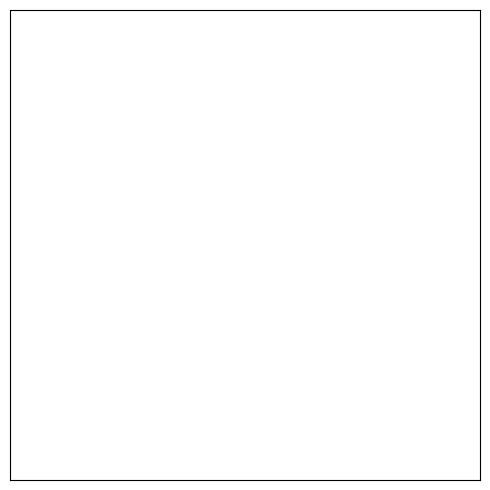

In [4]:
if __name__ == "__main__":
    ## Simulation with MPPI Controller 
    delta_t = 0.1  # [sec]
    sim_steps = 100  # [steps]
    # obstacle params
    OBSTACLE_CIRCLES = np.array([
        [+ 8.0, +5.0, 1.0],  # pos_x, pos_y, radius [m] in the global frame
        [+18.0, -5.0, 1.5],  # pos_x, pos_y, radius [m] in the global frame
    ])
    # initialize a differential drive robot as a control target
    robot = DifferentialDriveRobot(
        wheel_base=0.5,
        max_linear_vel=2.0,  # [m/s]
        max_angular_vel=2.0,  # [rad/s]
        obstacle_circles=OBSTACLE_CIRCLES,  # [obs_x, obs_y, obs_radius]
    )
    robot.reset(init_state=np.array([0.0, 0.0, 0.0]))
    # initialize a mppi controller for the differential drive robot
    mppi = MPPIControllerForDifferentialDrive(
        delta_t=delta_t*2.0,  # [s]
        wheel_base=0.5,  # [m]
        max_linear_vel=2.0,  # [m/s
        max_angular_vel=2.0,  # [rad/s]
        horizon_step_T=10,  # [steps]
        number_of_samples_K=50,  # [samples]
        param_exploration=0.05,
        param_lambda=100.0,
        param_alpha=0.98,
        sigma=np.array([[0.075, 0.0], [0.0, 2.0]]),
        # weight for [x, y, yaw, v]
        stage_cost_weight=np.array([50.0, 50.0, 1.0, 20.0]),
        # weight for [x, y, yaw, v]
        terminal_cost_weight=np.array([50.0, 50.0, 1.0, 20.0]),
        visualze_sampled_trajs=True, 
        visualize_optimal_traj=True,  
        obstacle_circles=OBSTACLE_CIRCLES,  # [obs_x, obs_y, obs_radius]
        collision_safety_margin_rate=1.2,  # safety margin for collision check
        )

    # simulation loop
    for i in range(sim_steps):
        # get current state of robot
        current_state = robot.get_state()

        try:
            # calculate input force with MPPI
            optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list = mppi.calc_control_input(observed_x=current_state)
        except IndexError as e:
            # the robot has reached the end of the reference path
            print("[ERROR] IndexError detected. Terminate simulation.")
            break

        # update states of robot
        robot.update(u=optimal_input, delta_t=delta_t, optimal_traj=optimal_traj[:, 0:2], sampled_traj_list=sampled_traj_list[:, :, 0:2])
        # stop when goal is reached
        goal_position = mppi.goal[:2]  # get goal's (x, y)
        pos_error = np.linalg.norm(current_state[:2] - goal_position)
        if pos_error < 0.5:
            print(f"[INFO] Goal reached at step {i}. Terminating simulation.")
            break

    # show animation
    robot.show_animation(interval_ms=int(delta_t * 1000))